In [ ]:
!pip install -U datasets

In [ ]:
import kagglehub
from datasets import load_dataset
import pandas as pd

In [ ]:
all_classes = [
    'anger',
    'disgust',
    'fear',
    'happy',
    'neutral',
    'sad',
    'surprise',

]

label2id = {label: i for i, label in enumerate(all_classes)}
id2label = {i: label for i, label in enumerate(all_classes)}

In [ ]:
import datasets
balanced_train_mix = datasets.load_from_disk("/content/drive/MyDrive/Dissertation/Final_Datasets/balanced_train_dataset_mix_merged")

In [ ]:
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix
)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)

    acc = accuracy_score(labels, preds)
    f1_macro = f1_score(labels, preds, average='macro')
    f1_weighted = f1_score(labels, preds, average='weighted')
    precision_macro = precision_score(labels, preds, average='macro')
    precision_weighted = precision_score(labels, preds, average='weighted')
    recall_macro = recall_score(labels, preds, average='macro')
    recall_weighted = recall_score(labels, preds, average='weighted')


    return {
        'accuracy': acc,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'precision_macro': precision_macro,
        'precision_weighted': precision_weighted,
        'recall_macro': recall_macro,
        'recall_weighted': recall_weighted
    }



In [ ]:
from transformers import DebertaV2Tokenizer, DebertaV2ForSequenceClassification


tokenizer = DebertaV2Tokenizer.from_pretrained("microsoft/deberta-v3-large")

model = DebertaV2ForSequenceClassification.from_pretrained(
    "microsoft/deberta-v3-large",
    num_labels=len(all_classes),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True  # IMPORTANT: allows head replacement
)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/580 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/874M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import TrainingArguments, Trainer

class FocalLoss(nn.Module):
    def __init__(self, weight=None, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.weight = weight
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, input, target):
        logp = F.log_softmax(input, dim=1)
        p = torch.exp(logp)
        logp = (1 - p) ** self.gamma * logp
        loss = F.nll_loss(logp, target, weight=self.weight, reduction=self.reduction)
        return loss


class FocalLossTrainer(Trainer):
    def __init__(self, class_weights, gamma, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights
        self.gamma = gamma

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        # Ensure weights are on same device
        weights = self.class_weights.to(logits.device)

        # Use focal loss
        loss_fn = FocalLoss(weight=weights, gamma=self.gamma)
        loss = loss_fn(logits, labels)

        return (loss, outputs) if return_outputs else loss




model.safetensors:   0%|          | 0.00/874M [00:00<?, ?B/s]

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Extract integer labels from training set
train_labels = balanced_train_mix["label"]
label_list = balanced_train_mix.features["label"].names

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.arange(len(label_list)), y=train_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float)

class_weights

tensor([1.2372, 1.7132, 1.9948, 0.4547, 0.6390, 1.0849, 2.3755])

In [ ]:
# Convert numpy array to PyTorch tensor
weights_tensor = torch.tensor(class_weights, dtype=torch.float)
weights_tensor = weights_tensor.to('cuda')

/tmp/ipython-input-9-73172990.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weights_tensor = torch.tensor(class_weights, dtype=torch.float)


In [ ]:
# Load the combined dataset
merged_dataset = datasets.load_from_disk("/content/drive/MyDrive/Dissertation/Final_Datasets/combined_emotion_dataset_3_class_original")

In [ ]:
def tokenize_fn(example):
    encoding = tokenizer(
        example['text'],
        truncation=True,
        padding=True,
        max_length=128
    )

    return encoding


train_data = balanced_train_mix.map(tokenize_fn)

Map:   0%|          | 0/57419 [00:00<?, ? examples/s]

In [ ]:
validation_data = merged_dataset['validation'].map(tokenize_fn, batched=True)

Map:   0%|          | 0/12682 [00:00<?, ? examples/s]

In [ ]:
train_data.set_format(type="torch", columns=['input_ids', 'attention_mask', 'token_type_ids', 'label'])
validation_data.set_format(type="torch", columns=['input_ids', 'attention_mask', 'token_type_ids', 'label'])


In [ ]:
from transformers import EarlyStoppingCallback, TrainerCallback
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [ ]:
# Training arguments
training_args = TrainingArguments(
    output_dir="./deberta-large-3-merged_augmented",
    eval_strategy ="epoch",
    save_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=2,
    num_train_epochs=20,
    weight_decay=0.01,
    lr_scheduler_type="cosine",
    logging_dir='./logs',
    logging_steps=50,
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    report_to="none",
    dataloader_num_workers=8



)

In [ ]:
trainer = FocalLossTrainer(
    class_weights=weights_tensor,
    gamma=2.0,  # You can try 1.0, 2.0, 1.5
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=validation_data,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[
        EarlyStoppingCallback(early_stopping_patience=3)
    ]
)


# Train!
trainer.train()

/tmp/ipython-input-7-3414854864.py:23: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `FocalLossTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted,Precision Macro,Precision Weighted,Recall Macro,Recall Weighted
1,0.386700,0.350597,0.755874,0.685681,0.762925,0.651971,0.785973,0.772217,0.755874
2,0.234000,0.211992,0.814698,0.787884,0.817412,0.755692,0.829220,0.836542,0.814698
3,0.178600,0.161565,0.842769,0.811419,0.844490,0.771537,0.853278,0.875781,0.842769
4,0.126100,0.137077,0.867135,0.858415,0.866932,0.847945,0.872916,0.875387,0.867135
5,0.077000,0.124205,0.894023,0.875066,0.893592,0.853728,0.896510,0.902033,0.894023
6,0.060800,0.119016,0.920833,0.917945,0.921118,0.917087,0.922505,0.919529,0.920833
7,0.046200,0.120915,0.925485,0.919151,0.925295,0.921756,0.926854,0.918434,0.925485
8,0.037300,0.125132,0.930531,0.919774,0.930486,0.914483,0.931672,0.926185,0.930531
9,0.027000,0.126162,0.945277,0.937508,0.945453,0.935412,0.946161,0.939954,0.945277
10,0.018900,0.130398,0.952610,0.941249,0.952651,0.940827,0.952871,0.942068,0.952610


TrainOutput(global_step=17960, training_loss=0.07430472512437002, metrics={'train_runtime': 11284.1183, 'train_samples_per_second': 101.77, 'train_steps_per_second': 1.592, 'total_flos': 9.404989927999085e+16, 'train_loss': 0.07430472512437002, 'epoch': 20.0})

In [ ]:
model_path_save = "/content/drive/MyDrive/Dissertation/Testing_models/deberta-large-3-merged_augmented"

trainer.save_model(model_path_save)
tokenizer.save_pretrained(model_path_save)

('/content/drive/MyDrive/Dissertation/Testing_models/deberta-large-3-merged_augmented/tokenizer_config.json',
 '/content/drive/MyDrive/Dissertation/Testing_models/deberta-large-3-merged_augmented/special_tokens_map.json',
 '/content/drive/MyDrive/Dissertation/Testing_models/deberta-large-3-merged_augmented/spm.model',
 '/content/drive/MyDrive/Dissertation/Testing_models/deberta-large-3-merged_augmented/added_tokens.json')

In [ ]:
import json

with open(f'{model_path_save}/label_mapping.json', 'w') as f:
    json.dump({
        "label2id": label2id,
        "id2label": id2label
    }, f)


In [ ]:
# Load model + tokenizer
from transformers import DebertaV2Tokenizer, DebertaV2ForSequenceClassification

tokenizer = DebertaV2Tokenizer.from_pretrained(model_path_save)
model = DebertaV2ForSequenceClassification.from_pretrained(model_path_save).to("cuda")
model.eval()

# Load label mappings
with open(f"{model_path_save}/label_mapping.json") as f:
    mapping = json.load(f)
id2label = {int(k): v for k, v in mapping['id2label'].items()}

# Inference example
text = "I am so unhappy today!"
inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
inputs = {k: v.to("cuda") for k, v in inputs.items()}

with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    predicted_class_id = torch.argmax(logits, dim=1).item()

print(f"Predicted class: {id2label[predicted_class_id]}")


Predicted class: sad


In [ ]:
metrics = trainer.evaluate()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Predict on validation set
predictions = trainer.predict(validation_data)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

# Classification report
print(classification_report(y_true, y_pred, target_names=label_list))



              precision    recall  f1-score   support

       anger       0.93      0.95      0.94      1658
     disgust       0.93      0.89      0.91        99
        fear       0.93      0.97      0.95      1028
       happy       0.97      0.97      0.97      4510
     neutral       0.96      0.94      0.95      3209
         sad       0.97      0.96      0.96      1890
    surprise       0.94      0.92      0.93       288

    accuracy                           0.96     12682
   macro avg       0.95      0.94      0.94     12682
weighted avg       0.96      0.96      0.96     12682



In [ ]:
test_dataset = merged_dataset['validation'].map(tokenize_fn, batched=True)
# After training
predictions = trainer.predict(test_dataset)
cm = confusion_matrix(predictions.label_ids, np.argmax(predictions.predictions, axis=1))

Map:   0%|          | 0/12682 [00:00<?, ? examples/s]

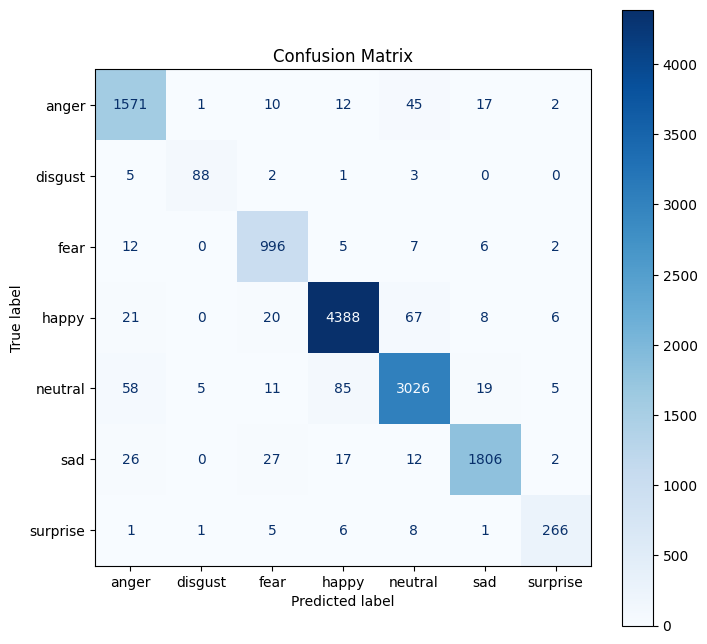

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_list)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()